# Machine Learning Exercise C

In [1]:
import warnings
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import table
from astroquery.gaia import Gaia
from astroquery.sdss import SDSS

warnings.filterwarnings('ignore')

Gaia.ROW_LIMIT = -1

plt.style.use("seaborn-darkgrid")
plt.rcParams['figure.figsize'] = [12, 8]

## Trained random forest model from notebook

In [2]:
# define cone
ra_cone = 180 * u.degree
dec_cone = 40 * u.degree
coord = SkyCoord(ra=ra_cone, dec=dec_cone, frame='icrs')
radius = 3 * u.degree
region_radius = radius / np.cos(np.deg2rad(coord.dec.degree))

In [3]:
# cone search in Gaia
job = Gaia.cone_search_async(coord, radius)
gaia_results = job.get_results()
gaia_results = gaia_results[(gaia_results["phot_g_mean_mag"] > 16) & (gaia_results["phot_g_mean_mag"] < 20.5) & (gaia_results["astrometric_params_solved"] == 31)]
print(f"Found {len(gaia_results)} Gaia sources")

INFO: Query finished. [astroquery.utils.tap.core]
Found 40942 Gaia sources


In [4]:
# cone search in SDSS for spectroscopic objects
specobj_fields = ["class", "sciencePrimary"]
photoobj_fields = ["ra", "dec", "type", "psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z"]
sdss_spec_results = SDSS.query_region(coord, region_radius, spectro=True, specobj_fields=specobj_fields, photoobj_fields=photoobj_fields)
sdss_spec_results = sdss_spec_results[(sdss_spec_results["sciencePrimary"] == 1) & (sdss_spec_results["type"] == 6)]
print(f"Found {len(sdss_spec_results)} SDSS spectroscopic sources, with {np.sum(sdss_spec_results['class'] == 'QSO')} QSOs")

Found 9273 SDSS spectroscopic sources, with 5219 QSOs


In [5]:
# cross match Gaia and SDSS and stack into single sources table
gaia_coord = SkyCoord(gaia_results["ra"], gaia_results["dec"], unit=u.degree)
sdss_spec_coord = SkyCoord(sdss_spec_results["ra"], sdss_spec_results["dec"], unit=u.degree)
idx, d2d, _ = gaia_coord.match_to_catalog_sky(sdss_spec_coord)
close_match = d2d < 1 * u.arcsec
gaia_matched = gaia_results[close_match]
sdss_spec_matched = sdss_spec_results[idx[close_match]]
sources = table.hstack([gaia_matched, sdss_spec_matched], table_names=["gaia", "sdss"])
print(f"Found {len(sources)} cross-matches between Gaia and SDSS spectroscopic sources, with {np.sum(sources['class'] == 'QSO')} QSOs")

Found 2909 cross-matches between Gaia and SDSS spectroscopic sources, with 1204 QSOs


In [6]:
# add feature columns to sources
pmtot = (sources["pmra"]**2 + sources["pmdec"]**2)**0.5
pmtot_error = (sources["pmra_error"]**2 + sources["pmdec_error"]**2 + 2 * sources["pmra_pmdec_corr"] * sources["pmra_error"] * sources["pmdec_error"])**0.5
sources["pm_significance"] = pmtot / pmtot_error
sources["u_g"] = sources["psfMag_u"] - sources["psfMag_g"]
sources["g_r"] = sources["psfMag_g"] - sources["psfMag_r"]
sources["r_i"] = sources["psfMag_r"] - sources["psfMag_i"]
sources["i_z"] = sources["psfMag_i"] - sources["psfMag_z"]

In [7]:
y = (sources["class"] == "QSO").astype(np.int)
features = ["pm_significance", "u_g", "g_r", "r_i", "i_z", "phot_g_mean_mag"]
X = np.empty((len(y), len(features)))
for i, feat in enumerate(features):
    X[:, i] = sources[feat]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [9]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0, n_jobs=1, class_weight="balanced_subsample")
model = clf.fit(X_train, y_train)

## Small cone search to find objects and predict whether QSOs

In [24]:
# define small cone
ra_cone = 180 * u.degree
dec_cone = 10 * u.degree
coord = SkyCoord(ra=ra_cone, dec=dec_cone, frame='icrs')
radius = 0.5 * u.degree
region_radius = radius / np.cos(np.deg2rad(coord.dec.degree))

In [25]:
# cone search in Gaia
job = Gaia.cone_search_async(coord, radius)
gaia_results = job.get_results()
gaia_results = gaia_results[(gaia_results["phot_g_mean_mag"] > 16) & (gaia_results["phot_g_mean_mag"] < 20.5) & (gaia_results["astrometric_params_solved"] == 31)]
print(f"Found {len(gaia_results)} Gaia sources")

INFO: Query finished. [astroquery.utils.tap.core]
Found 1406 Gaia sources


In [26]:
# cone search in SDSS for photometric objects
photoobj_fields = ["ra", "dec", "type", "psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z"]
sdss_phot_results = SDSS.query_region(coord, region_radius, photoobj_fields=photoobj_fields)
sdss_phot_results = sdss_phot_results[(sdss_phot_results["type"] == 6)]
print(f"Found {len(sdss_phot_results)} SDSS photometric sources")

Found 12657 SDSS photometric sources


In [27]:
# cross match Gaia and SDSS and stack into single sources table
gaia_coord = SkyCoord(gaia_results["ra"], gaia_results["dec"], unit=u.degree)
sdss_phot_coord = SkyCoord(sdss_phot_results["ra"], sdss_phot_results["dec"], unit=u.degree)
idx, d2d, _ = gaia_coord.match_to_catalog_sky(sdss_phot_coord)
close_match = d2d < 1 * u.arcsec
gaia_matched = gaia_results[close_match]
sdss_phot_matched = sdss_phot_results[idx[close_match]]
sources = table.hstack([gaia_matched, sdss_phot_matched], table_names=["gaia", "sdss"])
print(f"Found {len(sources)} cross-matches between Gaia and SDSS photometric sources")

Found 1360 cross-matches between Gaia and SDSS photometric sources


In [28]:
# add feature columns to sources
pmtot = (sources["pmra"]**2 + sources["pmdec"]**2)**0.5
pmtot_error = (sources["pmra_error"]**2 + sources["pmdec_error"]**2 + 2 * sources["pmra_pmdec_corr"] * sources["pmra_error"] * sources["pmdec_error"])**0.5
sources["pm_significance"] = pmtot / pmtot_error
sources["u_g"] = sources["psfMag_u"] - sources["psfMag_g"]
sources["g_r"] = sources["psfMag_g"] - sources["psfMag_r"]
sources["r_i"] = sources["psfMag_r"] - sources["psfMag_i"]
sources["i_z"] = sources["psfMag_i"] - sources["psfMag_z"]

In [29]:
features = ["pm_significance", "u_g", "g_r", "r_i", "i_z", "phot_g_mean_mag"]
X = np.empty((len(sources), len(features)))
for i, feat in enumerate(features):
    X[:, i] = sources[feat]

In [30]:
predictions = model.predict(X)
probabilities = model.predict_proba(X)[:, 1]

In [31]:
qsos = []
for i, num in enumerate(predictions):
    if num == 1:
        qsos.append(i)

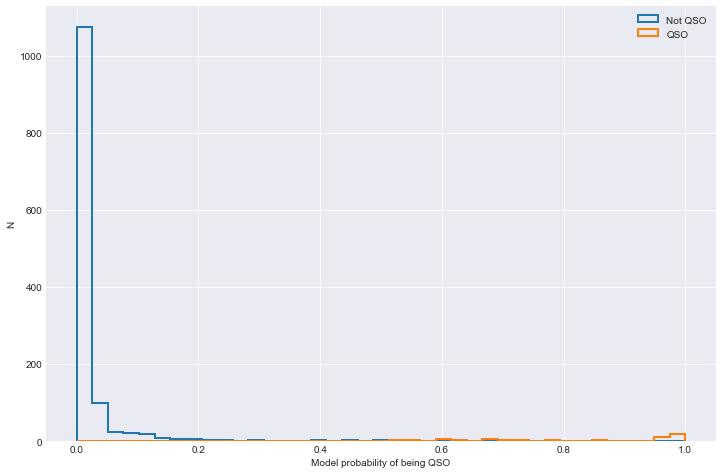

In [32]:
plt.hist(probabilities[predictions == 0], histtype="step", label="Not QSO", bins=np.linspace(0,1,40), lw=2)
plt.hist(probabilities[predictions == 1], histtype="step", label="QSO", bins=np.linspace(0,1,40), lw=2)
plt.xlabel("Model probability of being QSO")
plt.ylabel("N")
plt.legend()

In [33]:
# search SDSS for QSOs
for qso in qsos:
    ra = sources[qso]['ra_sdss'] * u.degree
    dec = sources[qso]['dec_sdss'] * u.degree
    coord = SkyCoord(ra=ra, dec=dec, frame='icrs')
    specobj_fields = ["class"]
    sdss_spec_results = SDSS.query_region(coord, spectro=True, specobj_fields=specobj_fields)
    if sdss_spec_results:
        print(f"Predicted QSO at index {qso} in sources is a {sdss_spec_results[0]['class']}")

Predicted QSO at index 113 in sources is a STAR
Predicted QSO at index 301 in sources is a QSO
Predicted QSO at index 531 in sources is a QSO
Predicted QSO at index 969 in sources is a QSO
Predicted QSO at index 1046 in sources is a QSO
Predicted QSO at index 1085 in sources is a QSO
Predicted QSO at index 1188 in sources is a QSO
Predicted QSO at index 1356 in sources is a GALAXY


In [34]:
len(qsos)

71

To manually check the predicted QSOs, I used the SDSS query to find spectroscopic data and check if the class was QSO. For the small cone using the same ra = 180 and dec = 40, all sources that had spectroscopic data were classed as QSOs, and the same when lowering to dec = 30 and 20 although the probability for being a QSO was decreasing. For dec = 10 and 0, the probability was very low and the model incorrectly classified quite a few of the known spectroscopic objects which were classed as stars or galaxies.